# This is a simple implementation of EfficientNet

In [4]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,GlobalAveragePooling2D

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


2024-11-30 16:54:48.068910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 16:54:48.084204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 16:54:48.088677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:54:48.099691: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 16:54:48.971840: W tensorflow/compiler/tf2

# **MBConv Block: Mobile Inverted Bottleneck Convolution**

The **MBConv block** is a fundamental building block in lightweight neural networks like **EfficientNet** and **MobileNetV2**. It is designed to achieve high accuracy with minimal computational cost, leveraging techniques such as inverted bottlenecks, depthwise separable convolutions, and optional squeeze-and-excitation (SE) blocks.

---

## **Key Components of MBConv Block**

### **1. Expansion Phase**
- **Purpose:** Expands the input tensor's channel dimensions to a higher-dimensional space, enabling the model to capture richer features.
- **Operation:** A `1 × 1` pointwise convolution is applied to increase the channel size.


---

### **2. Depthwise Convolution**
- **Purpose:** Performs spatial filtering independently on each channel.
- **Operation:** A `k × k` depthwise convolution is applied, significantly reducing the computational cost compared to traditional convolutions.


Where:
- `C`: Number of input channels.
- `C'`: Number of output channels.
- `k`: Kernel size.

---

### **3. Squeeze-and-Excitation (SE) Block** *(Optional)*
- **Purpose:** Introduces channel-wise attention by recalibrating the importance of each channel.
- **Steps:**
  1. **Squeeze:** Apply global average pooling to compute channel-wise statistics.
  2. **Excite:** Use fully connected layers to compute channel weights, followed by a sigmoid activation.
  3. **Scale:** Multiply the original feature map by the learned weights.

---

### **4. Projection Phase**
- **Purpose:** Reduces the expanded feature map back to the desired number of output channels.
- **Operation:** A `1 × 1` pointwise convolution compresses the channel dimensions.

---

### **5. Residual Connection**
- **Purpose:** Adds the input to the output if:
  1. The stride is `1`.
  2. The number of input and output channels are the same.
- **Benefit:** Improves gradient flow and stability during training.


---

## **Diagram of MBConv Block**

Input
  |

[ Expand (1x1 Conv) ]  -- Expand phase
  |

[ Depthwise Conv (k x k) ] -- Spatial convolution
  |

[ SE Block (optional) ] -- Channel attention
  |

[ Projection (1x1 Conv) ] -- Reduce channels
  |

[ Residual Connection (if applicable) ]
  |
  
Output


In [5]:
def mbConv_block(input, input_channels, output_channel, t, s):
    """
    Constructs an MBConv block using the functional API with an SE block.

    Parameters:
    - input: Input tensor.
    - input_channels: Number of input channels.
    - output_channels: Number of output channels.
    - t: Expansion factor.
    - s: Stride for depthwise convolution.

    Returns:
    - Output tensor from the MBConv block.
    """
    # Expansion
    expanded_filters = input_channels * t

    # Expansion Convolution
    x = Conv2D(expanded_filters, 1, padding='same', use_bias=False)(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Depthwise Convolution
    x = Conv2D(filters=expanded_filters, kernel_size=3, padding='same', strides=s, use_bias=False, groups=expanded_filters)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Squeeze-and-Excitation (SE) Block
    se = GlobalAveragePooling2D()(x)
    se = Dense(expanded_filters // 4, activation='swish')(se)  # First dense layer (bottleneck)
    se = Dense(expanded_filters, activation='sigmoid')(se)  # Second dense layer (recalibration)
    se = tf.keras.layers.Reshape((1, 1, expanded_filters))(se)  # Reshape to match the input shape
    x = tf.keras.layers.Multiply()([x, se])  # Apply channel-wise attention

    # Projection Convolution
    x = Conv2D(output_channel, kernel_size=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Skip connection (Residual connection)
    if s == 1 and input_channels == output_channel:
        x = tf.keras.layers.Add()([input, x])

    return x



# EfficientNet Architecture

EfficientNet is a family of convolutional neural networks (CNNs) that achieve state-of-the-art accuracy while being computationally efficient. The key innovation behind EfficientNet is the use of a compound scaling method that uniformly scales all dimensions of depth, width, and resolution using a set of fixed scaling coefficients.

## Key Components of EfficientNet

### 1. Compound Scaling
- **Purpose:** Efficiently scales the network to achieve better performance.
- **Method:** Uses a compound coefficient to uniformly scale network depth, width, and resolution.
- **Formula:** 
    \[
    \text{depth} = \alpha^d, \quad \text{width} = \beta^d, \quad \text{resolution} = \gamma^d
    \]
    where \( \alpha, \beta, \gamma \) are constants determined through a grid search, and \( d \) is the compound coefficient.

### 2. MBConv Blocks
- **Purpose:** Serve as the building blocks of EfficientNet, designed for efficiency and performance.
- **Components:** 
    - Expansion phase
    - Depthwise convolution
    - Squeeze-and-Excitation (SE) block (optional)
    - Projection phase
    - Residual connection (if applicable)

### 3. Squeeze-and-Excitation (SE) Blocks
- **Purpose:** Introduce channel-wise attention to recalibrate feature maps.
- **Steps:**
    1. **Squeeze:** Global average pooling to compute channel-wise statistics.
    2. **Excite:** Fully connected layers to compute channel weights, followed by a sigmoid activation.
    3. **Scale:** Multiply the original feature map by the learned weights.

### 4. Swish Activation Function
- **Purpose:** Improves model performance by providing a smooth, non-monotonic activation function.
- **Formula:** 
    \[
    \text{swish}(x) = x \cdot \text{sigmoid}(x)
    \]

## EfficientNet Variants
EfficientNet comes in several variants, each identified by a different scaling coefficient:
- **EfficientNet-B0:** Baseline model.
- **EfficientNet-B1 to B7:** Scaled versions of the baseline model, with increasing depth, width, and resolution.

## Advantages of EfficientNet
- **High Accuracy:** Achieves state-of-the-art performance on various benchmarks.
- **Computational Efficiency:** Requires fewer parameters and FLOPs compared to other models with similar accuracy.
- **Scalability:** The compound scaling method allows for easy scaling of the model to meet different resource constraints.

## Diagram of EfficientNet Architecture

```
Input
    |
[ Stem (Conv3x3) ]
    |
[ MBConv Block 1 ]
    |
[ MBConv Block 2 ]
    |
[ MBConv Block 3 ]
    |
[ MBConv Block 4 ]
    |
[ MBConv Block 5 ]
    |
[ MBConv Block 6 ]
    |
[ MBConv Block 7 ]
    |
[ Head (Conv1x1) ]
    |
[ Fully Connected Layer ]
    |
Output
```

In [6]:
def scaledResolution(phi):
    """
    Scaled Resolution function for EfficientNetB0-B7.
    """
    cases = {
        0: 224,
        1: 240,
        2: 260,
        3: 300,
        4: 380,
        5: 456,
        6: 528,
        7: 600
    }
    return cases[phi]

In [14]:
def efficientNetB0(input_shape=(224,224,3),num_classes=1000,phi=1):
    alpha = 1.2
    beta = 1.1
    gamma = 1.15

    depth = alpha ** phi
    width = beta ** phi
    scaled_resolution = scaledResolution(phi)
    scaled_input_shape = (scaled_resolution,scaled_resolution,input_shape[2])

    inputs = tf.keras.layers.Input(shape=scaled_input_shape)

    # Stem
    scaled_filters = int(32*width)
    x = Conv2D(scaled_filters,3,strides=2,padding='same',use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Block Configuration

    blocks_args = [
        (32,16,1,1,1), # Stage 1
        (16,24,6,2,int(1*depth)), # Stage 2
        (24,40,6,2,int(2*depth)), # Stage 3
        (40,80,6,2,int(2*depth)), # Stage 4
        (80,112,6,1,int(3*depth)), # Stage 5
        (112,192,6,2,int(3*depth)), # Stage 6
        (192,320,6,1,int(4*depth)), # Stage 7    
        (320,1280,6,1,int(1*depth)) # Stage 8
    ]

    # MbConv Blocks
    for (input_channels,output_channels,t,s,repeats) in blocks_args:
        for i in range(repeats):
            x = mbConv_block(
                x,
                input_channels=input_channels if i == 0 else output_channels,
                output_channel=output_channels,
                t=t,
                s=s if i == 0 else 1
            )

    # Head
    scaled_filters = int(1280*width)
    x = Conv2D(scaled_filters,1,padding='same',use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs,outputs=x)

    return model

In [15]:
model = efficientNetB0(num_classes=10,phi=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │        945 │ input_layer_3[0]… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        140 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 120, 120,  │      1,120 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 120, 120,  │        288 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_5[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        288 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 120, 120,  │          0 │ activation_5[0][… │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 120, 120,  │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │         64 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 120, 120,  │      1,536 │ batch_normalizat

 Total params: 21,423,595 (81.72 MB)

 Trainable params: 21,353,749 (81.46 MB)

 Non-trainable params: 69,846 (272.84 KB)

In [16]:
def preprocess(data , labels, num_classes=10, target_shape=(240, 240)):
    
    data = tf.image.resize(data, target_shape)
    data = data/255.0
    labels = tf.squeeze(labels)  # Remove extra dimensions (e.g., from (32, 1) to (32,))
    labels = to_categorical(labels, num_classes)
    return data , labels

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_val, y_val) = x_train[40000:], y_train[40000:]

x_train = x_train[:40000]
y_train = y_train[:40000]

# Create datasets and preprocess them
batch_size = 32
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Example: Iterate over the dataset
for batch_images, batch_labels in train_dataset.take(1):  # Process only one batch for demonstration
    print(f"Batch image shape: {batch_images.shape}")  # Expected: (batch_size, 240, 240, 3)
    print(f"Batch label shape: {batch_labels.shape}")  # Expected: (batch_size, 10)


Batch image shape: (32, 240, 240, 3)
Batch label shape: (32, 10)


2024-11-30 16:56:11.499009: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5


I0000 00:00:1732978604.635363   84107 service.cc:146] XLA service 0x7201c8002930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732978604.635388   84107 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-30 16:56:45.503671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 16:56:48.629513: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-30 16:56:54.046270: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-30 16:56:54.951901: W external/local_tsl/tsl/framework/bfc_allocator.cc:291]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2243 - loss: 2.0050

2024-11-30 17:00:39.093770: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-30 17:00:39.320755: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 163ms/step - accuracy: 0.2243 - loss: 2.0048 - val_accuracy: 0.3357 - val_loss: 2.1190
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.5019 - loss: 1.3501 - val_accuracy: 0.4743 - val_loss: 1.8217
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 196s 157ms/step - accuracy: 0.6259 - loss: 1.0501 - val_accuracy: 0.5938 - val_loss: 1.1812
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 157ms/step - accuracy: 0.6935 - loss: 0.8674 - val_accuracy: 0.6421 - val_loss: 1.0618
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/step - accuracy: 0.7392 - loss: 0.7464 - val_accuracy: 0.6475 - val_loss: 1.1375


In [25]:
efficientNetB0_model = efficientNetB0(num_classes=10,phi=1)


In [26]:
efficientNetB0_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_215 (Conv2D) │ (None, 120, 120,  │        945 │ input_layer_7[0]… │
│                     │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        140 │ conv2d_215[0][0]  │
│ (BatchNormalizatio… │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_147      │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_216 (Conv2D) │ (None, 120, 120,  │      1,120 │ activation_147[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        128 │ conv2d_216[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_148      │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 120, 120,  │        288 │ activation_148[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │        128 │ conv2d_217[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_149      │ (None, 120, 120,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_149[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 32)        │        288 │ dense_140[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_68          │ (None, 1, 1, 32)  │          0 │ dense_141[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_68         │ (None, 120, 120,  │          0 │ activation_149[0… │
│ (Multiply)          │ 32)               │            │ reshape_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_218 (Conv2D) │ (None, 120, 120,  │        512 │ multiply_68[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 120, 120,  │         64 │ conv2d_218[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,423,595 (81.72 MB)

 Trainable params: 21,353,749 (81.46 MB)

 Non-trainable params: 69,846 (272.84 KB)

In [27]:
efficientNetB0_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = efficientNetB0_model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 246s 160ms/step - accuracy: 0.2705 - loss: 1.9039 - val_accuracy: 0.4261 - val_loss: 1.8918
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 195s 156ms/step - accuracy: 0.5785 - loss: 1.1610 - val_accuracy: 0.5746 - val_loss: 1.3561
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 157ms/step - accuracy: 0.6825 - loss: 0.8926 - val_accuracy: 0.6691 - val_loss: 0.9714
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.7455 - loss: 0.7312 - val_accuracy: 0.6751 - val_loss: 1.0806
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.7873 - loss: 0.6127 - val_accuracy: 0.7405 - val_loss: 0.7967
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.8212 - loss: 0.5157 - val_accuracy: 0.7468 - val_loss: 0.8151
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 158ms/step - accuracy: 0.8506 - loss: 0.4309 - val_accuracy: 0.7639 - val_loss: 0.7802
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 196s 157ms/step - ac

In [29]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

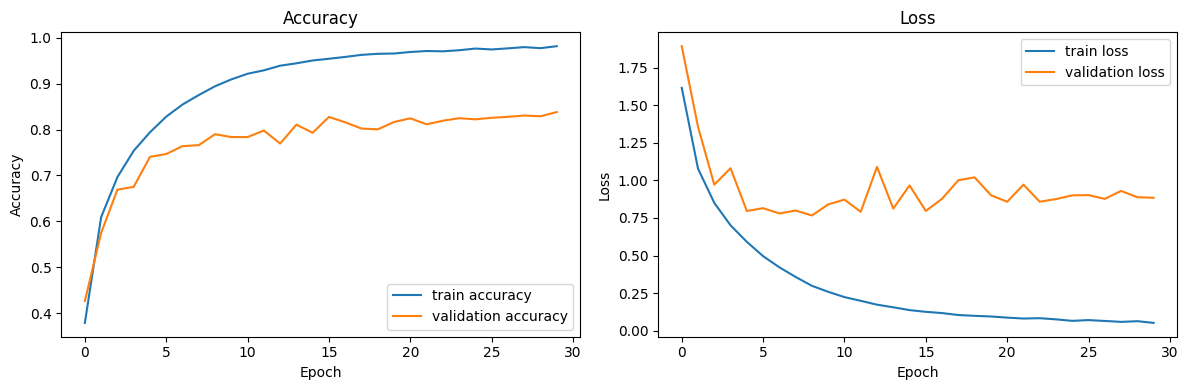

In [30]:
plot_history(history)

In [31]:
def evaluate_model(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {accuracy}")
    print(f"Test loss: {loss}")


In [32]:
evaluate_model(efficientNetB0_model, test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8291 - loss: 0.9432
Test accuracy: 0.8282999992370605
Test loss: 0.9371155500411987


In [35]:
def plot_predictions(model, dataset):
    plt.figure(figsize=(12, 12))
    classes = [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"
    ]
    for i, (images, labels) in enumerate(dataset.take(1)):
        pred = model.predict(images)
        for j in range(9):
            plt.subplot(3, 3, j + 1)
            plt.imshow(images[j])
            plt.title(f"Actual: {classes[labels[j].numpy().argmax()]}\nPredicted: {classes[pred[j].argmax()]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2024-11-30 19:04:12.207700: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


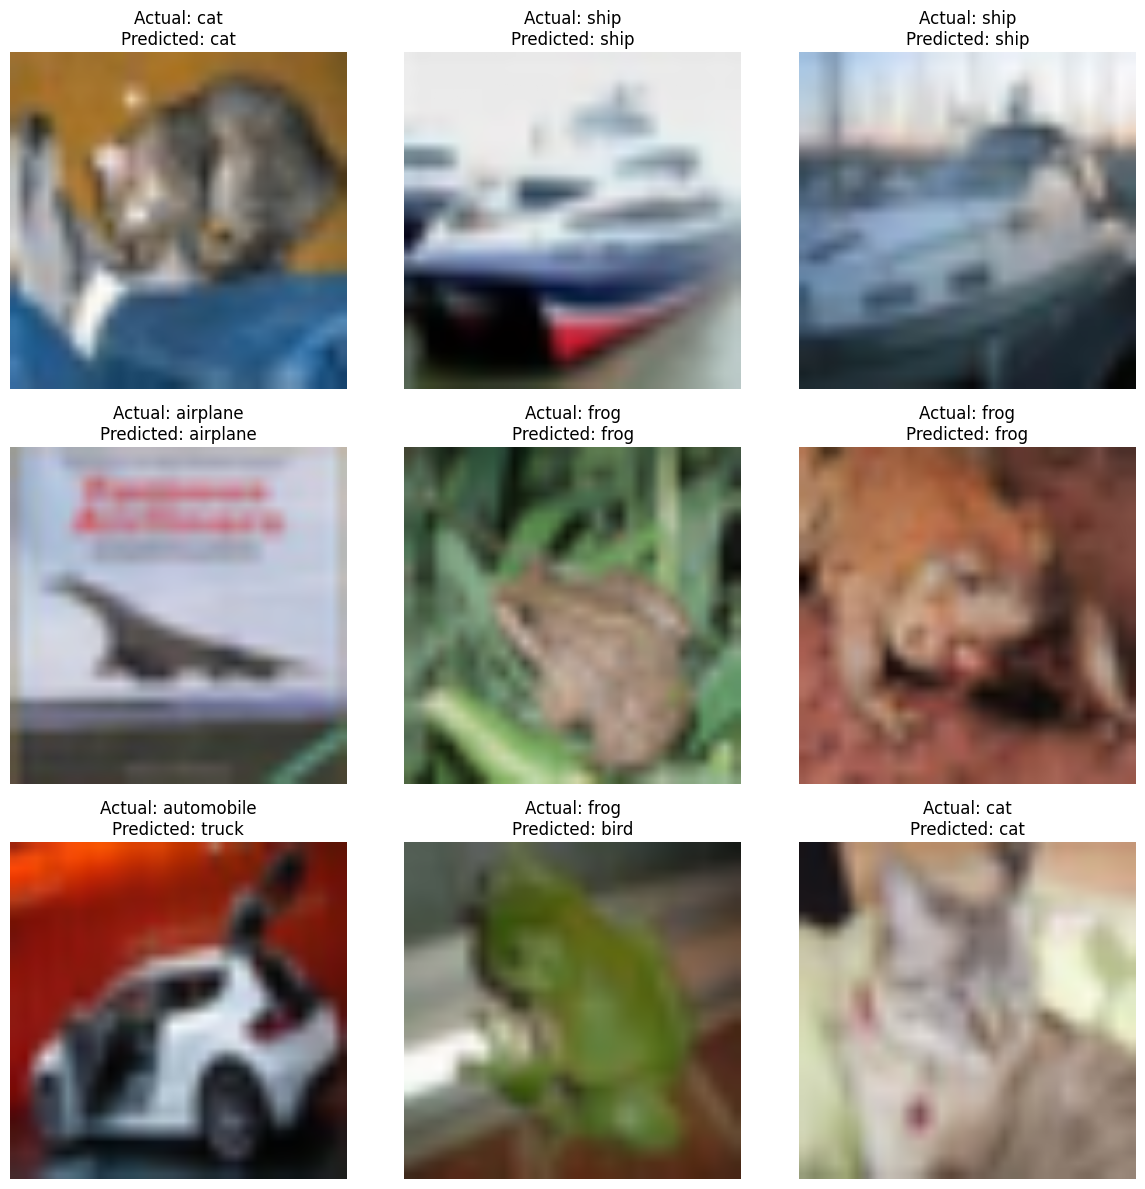

In [36]:
plot_predictions(efficientNetB0_model, test_dataset)

In [37]:
efficientNetB0_model.save('efficientNetB0_model.keras')